In [1]:
from __future__ import print_function
import pickle 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from sub import subMNIST
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Files already downloaded
3000
750


In [2]:
#Set labels to zeros as a dummy values to make the train_loader work 

trainset_unlabeled = pickle.load(open("train_unlabeled.p", "rb")) 
trainset_unlabeled.train_labels = torch.zeros(trainset_unlabeled.train_data.size(0))
train_loader  = torch.utils.data.DataLoader(trainset_unlabeled, batch_size=64, shuffle=True, num_workers=2)

validset = pickle.load(open("validation.p", "rb"))
valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True, num_workers=2)

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # q(z|x) -> Bayesian Perspective
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # reparameterization trick to make the sample subject to random noise 
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    # p(x|z) -> Generative Perspective
    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
params = list(model.parameters())

print(model)
print('Models has {} learnable paramater:'.format(len(params)))
[print('parameter {} has a size of {}'.format(i+1, params[i].size())) for i in range(len(params))]

VAE (
  (fc1): Linear (784 -> 400)
  (fc21): Linear (400 -> 20)
  (fc22): Linear (400 -> 20)
  (fc3): Linear (20 -> 400)
  (fc4): Linear (400 -> 784)
  (relu): ReLU ()
  (sigmoid): Sigmoid ()
)
Models has 10 learnable paramater:
parameter 1 has a size of torch.Size([400, 784])
parameter 2 has a size of torch.Size([400])
parameter 3 has a size of torch.Size([20, 400])
parameter 4 has a size of torch.Size([20])
parameter 5 has a size of torch.Size([20, 400])
parameter 6 has a size of torch.Size([20])
parameter 7 has a size of torch.Size([400, 20])
parameter 8 has a size of torch.Size([400])
parameter 9 has a size of torch.Size([784, 400])
parameter 10 has a size of torch.Size([784])


[None, None, None, None, None, None, None, None, None, None]

In [4]:
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False

def loss_function(recon_x, x, mu, logvar): 
    """(Gaussian) Kullback-Leibler divergence KL(q||p), per training example"""
    
    BCE = reconstruction_function(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-3)

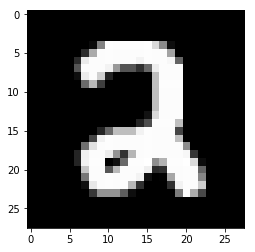

In [5]:
#Test Image

dataiter = iter(train_loader)
images, labels = dataiter.next()
test_image = images[1][0]
np_test_image = test_image.numpy()
plt.imshow(np_test_image, cmap = 'gray')

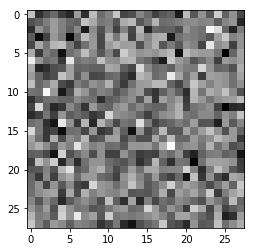

In [6]:
#Ask the model before traning to reconstrcut the "test image"

output = model(Variable(test_image))
reconstrcuted_image = output[0].data.view(28,28).numpy()
plt.imshow(reconstrcuted_image, cmap = 'gray')

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 20 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    # Ask the model after training to reconstrcut the "test image"
    
    output = model(Variable(test_image)) 
    reconstrcuted_image = output[0].data.view(28,28).numpy()
    plt.imshow(reconstrcuted_image, cmap = 'gray')  

In [8]:
def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in valid_loader:
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0] 

    test_loss /= len(valid_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Train Epoch: 1 [0/47000 (0%)]	Loss: 550.859436
Train Epoch: 1 [1280/47000 (3%)]	Loss: -3944.977051
Train Epoch: 1 [2560/47000 (5%)]	Loss: -4929.130859
Train Epoch: 1 [3840/47000 (8%)]	Loss: -5064.358887
Train Epoch: 1 [5120/47000 (11%)]	Loss: -5892.219238
Train Epoch: 1 [6400/47000 (14%)]	Loss: -6241.758301
Train Epoch: 1 [7680/47000 (16%)]	Loss: -6994.364746
Train Epoch: 1 [8960/47000 (19%)]	Loss: -7292.389160
Train Epoch: 1 [10240/47000 (22%)]	Loss: -7662.237793
Train Epoch: 1 [11520/47000 (24%)]	Loss: -7747.131348
Train Epoch: 1 [12800/47000 (27%)]	Loss: -8094.465820
Train Epoch: 1 [14080/47000 (30%)]	Loss: -8057.169922
Train Epoch: 1 [15360/47000 (33%)]	Loss: -7998.875000
Train Epoch: 1 [16640/47000 (35%)]	Loss: -8354.772461
Train Epoch: 1 [17920/47000 (38%)]	Loss: -8640.177734
Train Epoch: 1 [19200/47000 (41%)]	Loss: -8696.521484
Train Epoch: 1 [20480/47000 (44%)]	Loss: -8841.162109
Train Epoch: 1 [21760/47000 (46%)]	Loss: -8649.681641
Train Epoch: 1 [23040/47000 (49%)]	Loss: -869

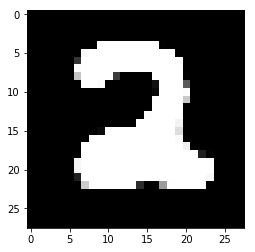

In [9]:
for epoch in range(1, 2):
    train(epoch)
    test(epoch)

# The start of the semi_supervised model

In [16]:
trainset_labeled = pickle.load(open("train_labeled.p", "rb")) 
train_loader  = torch.utils.data.DataLoader(trainset_labeled, batch_size=64, shuffle=True, num_workers=2)

In [68]:
for p in model.parameters():
     p.requires_grad = False

In [69]:
class SemiSupervised(nn.Module):
    def __init__(self):
        super(SemiSupervised, self).__init__()

        self.fc1 = nn.Linear(20, 15)
        self.fc2 = nn.Linear(15, 10)
        
    def forward(self, x):
        
        mu, logvar = model.encode(x.view(-1, 784))
        z = model.reparametrize(mu, logvar)
        x = F.relu(self.fc1(z))
        return F.sigmoid(F.relu(self.fc2(x)))
            
        

In [70]:
semi_model = SemiSupervised()
optimizer = optim.Adam(semi_model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()


In [71]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = Variable(data)
        target = Variable(target)
        optimizer.zero_grad()
        output = semi_model(data) 
        loss =  loss_function(output, target) 
        loss.backward() 
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


In [72]:
def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:

        data, target = Variable(data, volatile=True), Variable(target)
        output = semi_model(data)
        test_loss += loss_function(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [73]:
for epoch in range(1, 20):
    train(epoch)
    test(epoch, valid_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.276165
Train Epoch: 1 [640/3000 (21%)]	Loss: 2.277667
Train Epoch: 1 [1280/3000 (43%)]	Loss: 2.244603
Train Epoch: 1 [1920/3000 (64%)]	Loss: 2.240822
Train Epoch: 1 [2560/3000 (85%)]	Loss: 2.221900

Test set: Average loss: 2.2089, Accuracy: 3640/10000 (36%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 2.191455
Train Epoch: 2 [640/3000 (21%)]	Loss: 2.182140
Train Epoch: 2 [1280/3000 (43%)]	Loss: 2.165468
Train Epoch: 2 [1920/3000 (64%)]	Loss: 2.182326
Train Epoch: 2 [2560/3000 (85%)]	Loss: 2.102584

Test set: Average loss: 2.1349, Accuracy: 5458/10000 (55%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 2.115494
Train Epoch: 3 [640/3000 (21%)]	Loss: 2.118392
Train Epoch: 3 [1280/3000 (43%)]	Loss: 2.106713
Train Epoch: 3 [1920/3000 (64%)]	Loss: 2.113840
Train Epoch: 3 [2560/3000 (85%)]	Loss: 2.122356

Test set: Average loss: 2.0780, Accuracy: 6532/10000 (65%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 2.062775
Train Epoch: 4 [640/3000 (21%)]	Loss: 2.045774
Train Epoch: 4 [1280/